In [1]:
import sys
sys.path.append('../03-code/')
import pandas as pd
from config import PROJECT_ROOT_DIRECTORY, COLUMNS_DICT
from rdkit import Chem


In [2]:
# DJ raw smiles are taken from 05-figures/01-molecular-representation/01-existing-spacers/numberated-DJ-spacer.cdxml
existing_raw_smiles_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/13-existing-molecule/reported-lowD-raw-smiles.csv')
for i in existing_raw_smiles_dataframe.index:
    smiles_raw = existing_raw_smiles_dataframe.loc[i,'smiles_raw']
    mol = Chem.MolFromSmiles(smiles_raw)
    smiles_canonical = Chem.MolToSmiles(mol)
    existing_raw_smiles_dataframe.loc[i,'smiles_canonical'] = smiles_canonical

existing_raw_smiles_dataframe.set_index('existing_identifier',inplace=True)

# sort the rows by the existing_identifier
existing_raw_smiles_dataframe.sort_index(inplace=True)

existing_smiles_dataframe = existing_raw_smiles_dataframe.drop(columns='smiles_raw')
existing_smiles_dataframe.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/13-existing-molecule/reported-lowD-canonical-smiles.csv',index=True)

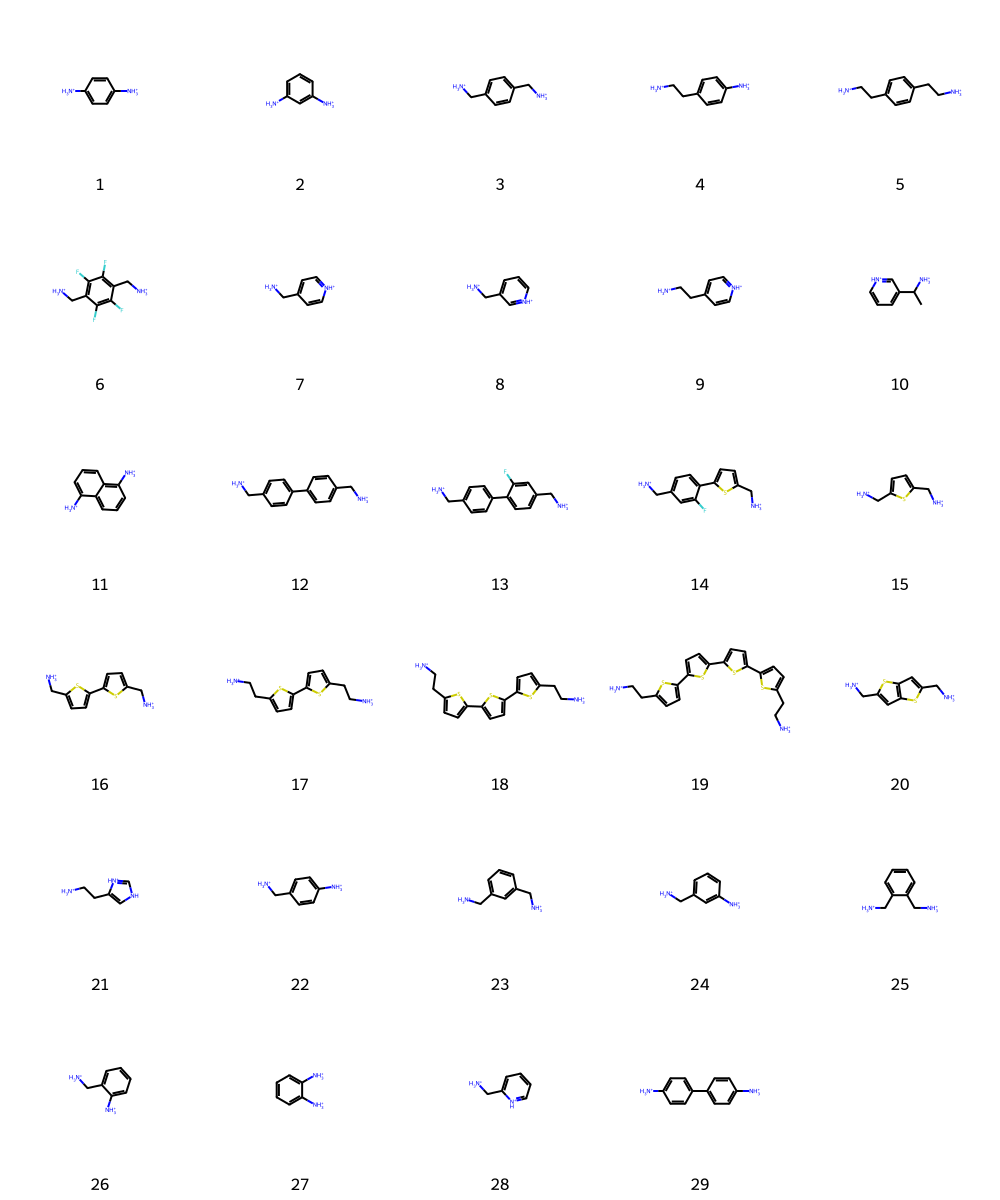

In [2]:
from utils import visualize_smiles_list
existing_smiles_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/13-existing-molecule/reported-lowD-canonical-smiles.csv',index_col=0)
legends = [f'{index}' for index in existing_smiles_dataframe.index]
visualize_smiles_list(existing_smiles_dataframe['smiles_canonical'].tolist(),
                      legends=legends)

In [3]:
import csv
from rdkit import Chem
from config import COLUMNS_DICT
from synthesis_feasibility_helper import calculate_topological_formability_descriptors, calculate_general_formability_descriptors
from organic_featurization_helper import get_organic_structure_descriptors

def generate_formability_csv_file_from_smiles(input_csv, output_csv):
    """
    Read the SMILES and sequences from an input CSV, compute the existence in pubchem,
    and write the results to an output CSV file.
    
    Parameters:
    - input_csv: Path to the input CSV containing SMILES and sequences.
    - output_csv: Path to the output CSV file where results will be saved.
    """
    with open(input_csv, 'r') as infile, open(output_csv, 'w', newline='') as outfile:
        reader = csv.DictReader(infile)
        fieldnames = ['existing_identifier','smiles_canonical','reported_2D','reported_otherD','STEI','NumRot_tail','eccentricity','disNN','NumN']  # Add functional group names as columns
        fieldnames = fieldnames + list(COLUMNS_DICT['2D_formability_general_descriptors']) + ['linker_position']

        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        
        # Write the header to the output CSV
        writer.writeheader()
        # Process each row (SMILES and sequence) in the input CSV
        for row in reader:
            existing_identifier = row['existing_identifier']
            smiles_canonical = row['smiles_canonical']
            reported_2D = row['reported_2D']
            reported_otherD = row['reported_otherD']
            
            # calculate the formability descriptors of molecule in pubchem
            mol = Chem.MolFromSmiles(smiles_canonical)
            topological_formability_descriptors_dict = calculate_topological_formability_descriptors(mol)
            general_formability_descriptors_dict = calculate_general_formability_descriptors(mol)
            organic_structure_descriptors_dict = get_organic_structure_descriptors(smiles_canonical)
            output_row = {
                'existing_identifier': existing_identifier,
                'smiles_canonical': smiles_canonical,
                'reported_2D': reported_2D,
                'reported_otherD': reported_otherD,
            }
            
            output_row.update(topological_formability_descriptors_dict)  # Add fingerprint data to the row
            output_row.update(general_formability_descriptors_dict)  # Add fingerprint data to the row   
            output_row.update({'linker_position': organic_structure_descriptors_dict['linker_position']})
            # Write the row to the output CSV
            writer.writerow(output_row)

In [4]:
input_csv = PROJECT_ROOT_DIRECTORY+'01-rawdata/13-existing-molecule/reported-lowD-canonical-smiles.csv'
output_csv = PROJECT_ROOT_DIRECTORY+'01-rawdata/13-existing-molecule/reported-lowD-formability-descriptors.csv'
generate_formability_csv_file_from_smiles(input_csv, output_csv)

### Visualize the relationship between formability descriptors and reported dimension

In [2]:
reported_lowD_formability_descriptors_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/13-existing-molecule/reported-lowD-formability-descriptors.csv')

In [6]:
reported_lowD_formability_descriptors_dataframe.columns

Index(['existing_identifier', 'smiles_canonical', 'reported_2D',
       'reported_otherD', 'STEI', 'NumRot_tail', 'eccentricity', 'disNN',
       'NumN', 'MolWt', 'NumHeteroatoms', 'NumRotatableBonds', 'FractionCSP3',
       'Kappa1', 'Kappa2', 'Kappa3', 'NumAromaticCarbocycles',
       'NumAromaticRings', 'NumAmideBonds', 'NumAtomStereoCenters',
       'NumBridgeheadAtoms', 'NumSaturatedCarbocycles',
       'NumAliphaticCarbocycles', 'NumAromaticHeterocycles',
       'NumAliphaticRings', 'NumLipinskiHBA', 'NumLipinskiHBD', 'NumRings',
       'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumSpiroAtoms',
       'NumUnspecifiedAtomStereoCenters', 'NumHeterocycles', 'LargestRingSize',
       'linker_position'],
      dtype='object')

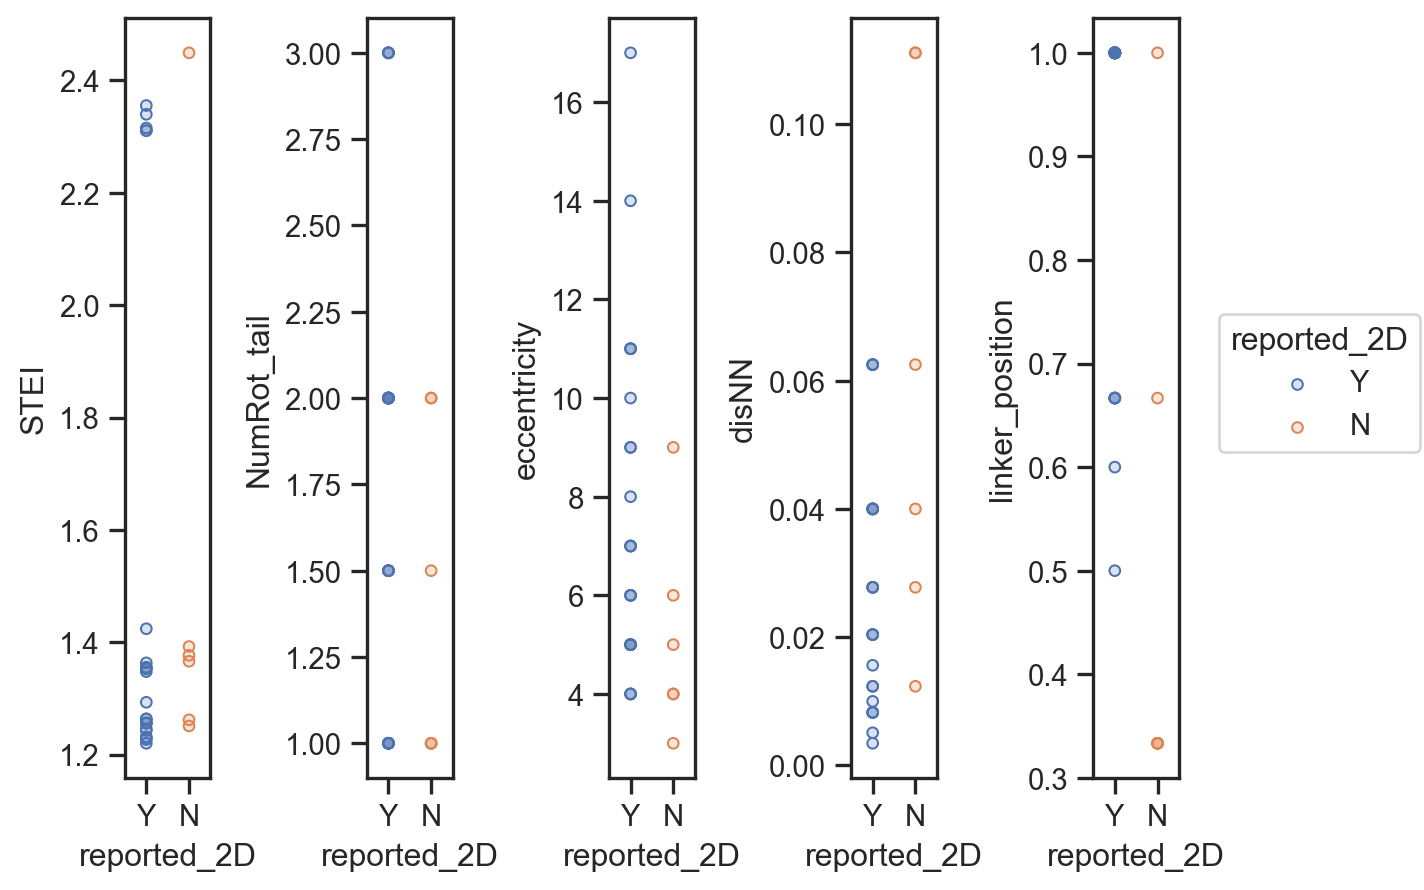

In [8]:
import seaborn.objects as so
from seaborn import axes_style

(
    so.Plot(data=reported_lowD_formability_descriptors_dataframe,x='reported_2D',color='reported_2D')
    .pair(y=['STEI','NumRot_tail','eccentricity','disNN','linker_position'],wrap=1)
    .add(so.Dots())
    .theme(axes_style('ticks'))
)

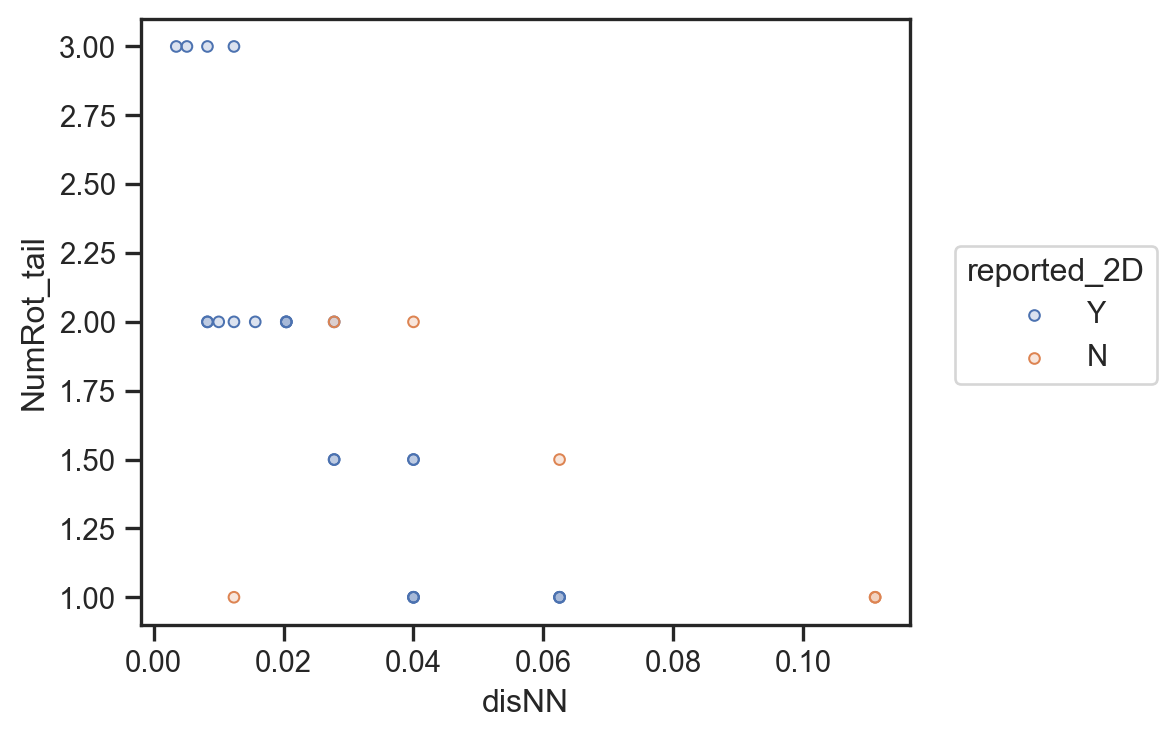

In [4]:
import seaborn.objects as so
from seaborn import axes_style

(
    so.Plot(data=reported_lowD_formability_descriptors_dataframe,x='disNN',y='NumRot_tail',color='reported_2D')
    .add(so.Dots())
    .theme(axes_style('ticks'))
    .layout(size=(5,4))
)

In [7]:
# using plotly to draw the scatter plot
# hover information includes the molecule identifier
import plotly.express as px
fig = px.scatter(reported_lowD_formability_descriptors_dataframe, x='STEI', y='disNN', color='reported_2D', symbol='reported_otherD',hover_name='existing_identifier')
fig.show()

#### scale all the formability descriptors

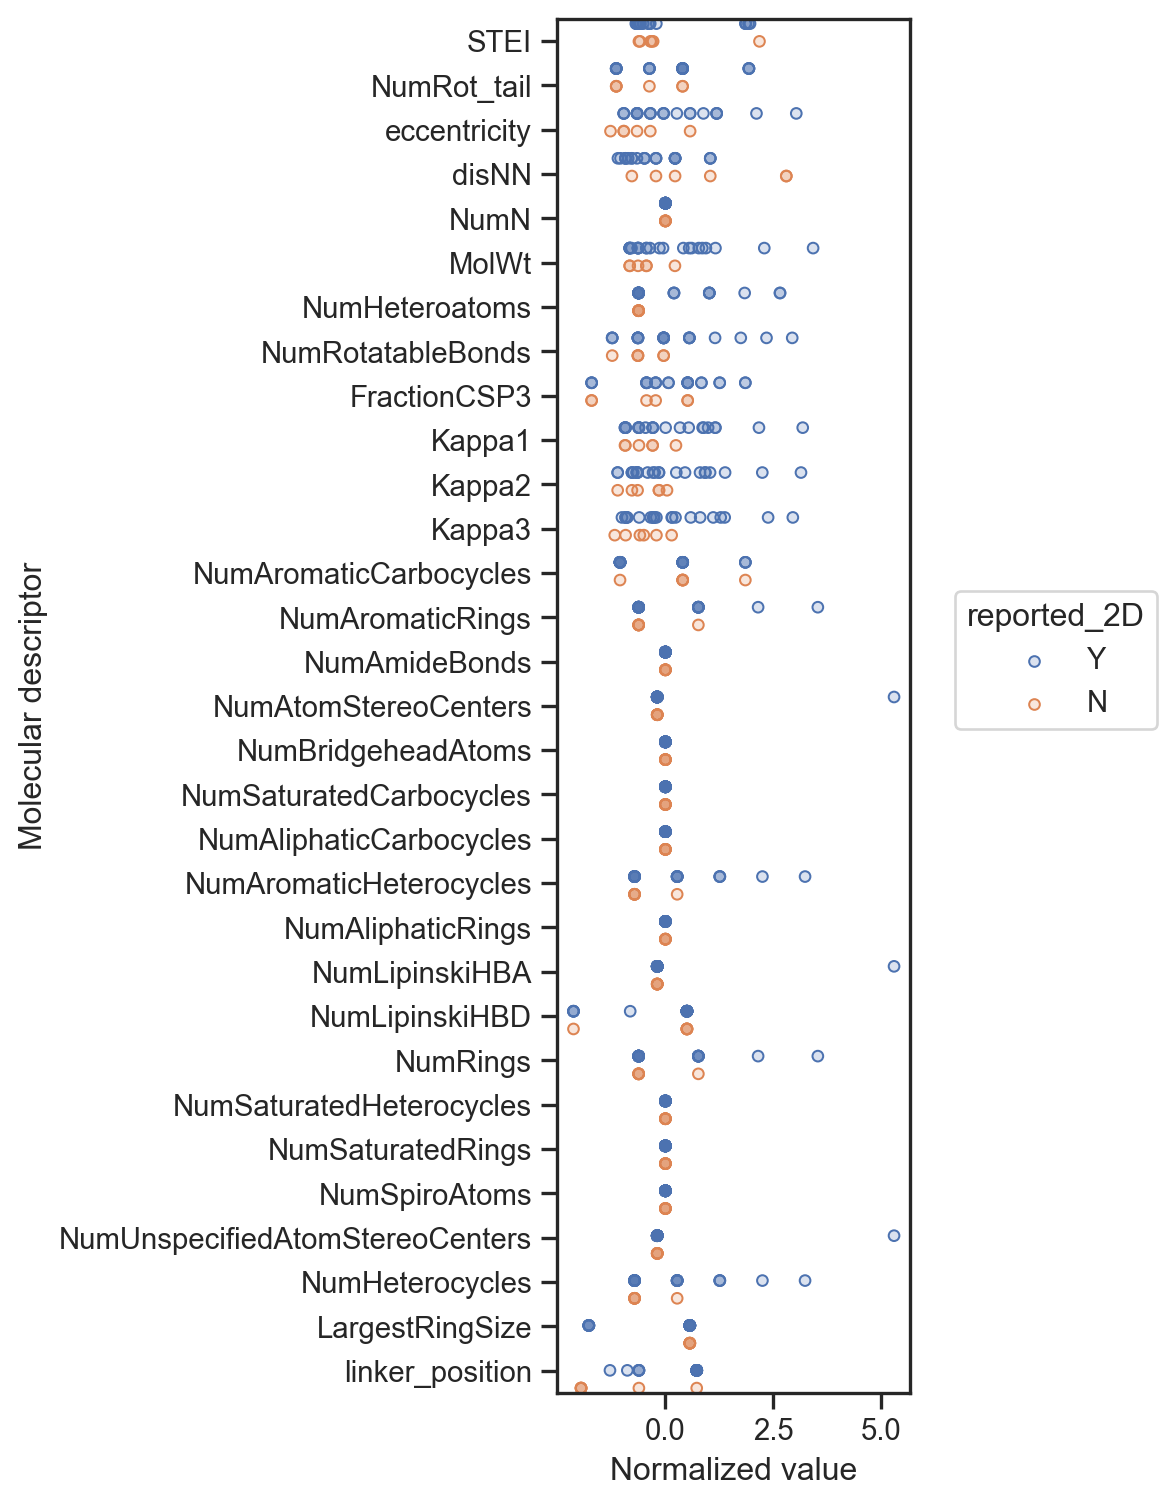

In [5]:
from sklearn import preprocessing
# normalize the formability descriptors

features_to_normalize = reported_lowD_formability_descriptors_dataframe.iloc[:,4:].values

normalized_features = preprocessing.StandardScaler().fit_transform(features_to_normalize)

# add the existing_identifier, smiles_canonical, reported_2D, and reported_otherD columns back to the normalized dataframe
normalized_formability_descriptors_dataframe = pd.DataFrame(normalized_features,columns=reported_lowD_formability_descriptors_dataframe.columns[4:])

normalized_formability_descriptors_dataframe = pd.concat([reported_lowD_formability_descriptors_dataframe.iloc[:,0:4],
                                                          normalized_formability_descriptors_dataframe],axis=1)

(
    so.Plot(data=pd.melt(normalized_formability_descriptors_dataframe,id_vars=['existing_identifier','smiles_canonical','reported_2D','reported_otherD']),
            y='variable',x='value',color='reported_2D',group = 'variable')
    #.add(so.Range(),so.Norm(),so.Dodge())
    .add(so.Dots(),so.Dodge())
    .theme(axes_style('ticks'))
    .layout(size=(5,8))
    .label(x='Normalized value', y='Molecular descriptor')
)

### calculate formability score

In [2]:
reported_lowD_formability_descriptors_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/13-existing-molecule/reported-lowD-formability-descriptors.csv')
reported_formability_descriptors_dataframe = reported_lowD_formability_descriptors_dataframe[['existing_identifier','smiles_canonical','reported_2D','STEI','NumRot_tail','eccentricity','disNN','linker_position']]

In [3]:
from sklearn import preprocessing
# normalize the formability descriptors

features_to_normalize = reported_formability_descriptors_dataframe.iloc[:,3:].values
standard_scaler = preprocessing.StandardScaler().fit(features_to_normalize)
normalized_features = standard_scaler.transform(features_to_normalize)

normalized_formability_descriptors_dataframe = pd.DataFrame(normalized_features,columns=reported_formability_descriptors_dataframe.columns[3:])
normalized_formability_descriptors_dataframe = pd.concat([reported_formability_descriptors_dataframe.iloc[:,0:3],
                                                          normalized_formability_descriptors_dataframe],axis=1)

In [4]:
import json

# Create dictionary in the desired format
scaler_params_dict = {
    feature: {
        "mean": mean,
        "scale": scale
    }
    for feature, mean, scale in zip(reported_formability_descriptors_dataframe.columns[3:],
                                    standard_scaler.mean_,
                                    standard_scaler.scale_)
}


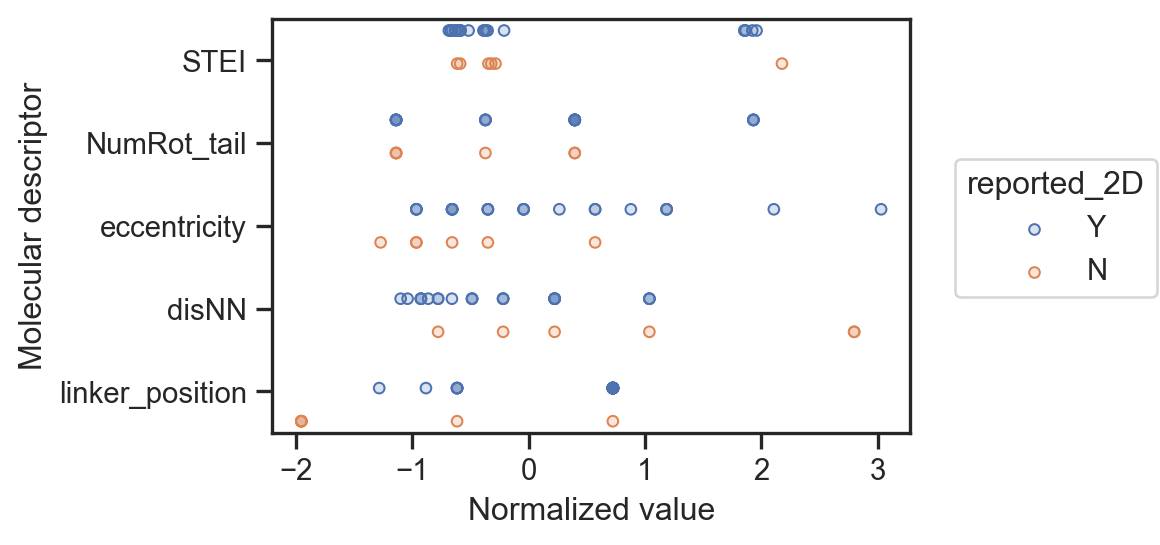

In [5]:
import seaborn.objects as so
from seaborn import axes_style
(
    so.Plot(data=pd.melt(normalized_formability_descriptors_dataframe,id_vars=['existing_identifier','smiles_canonical','reported_2D']),
            y='variable',x='value',color='reported_2D',group = 'variable')
    #.add(so.Range(),so.Norm(),so.Dodge())
    .add(so.Dots(),so.Dodge())
    .theme(axes_style('ticks'))
    .layout(size=(5,3))
    .label(x='Normalized value', y='Molecular descriptor')
)

### obtain parameters for formability score

Descriptor: STEI, Threshold type: maximum
Fitted parameters: a = -156.2588, b = -2.0604
Descriptor: eccentricity, Threshold type: minimum
Fitted parameters: a = 117.7296, b = 1.1124
Descriptor: linker_position, Threshold type: minimum
Fitted parameters: a = 54.5578, b = 1.6425
Descriptor: NumRot_tail, Threshold type: minimum
Fitted parameters: a = 43.2492, b = 1.5286
Descriptor: disNN, Threshold type: maximum
Fitted parameters: a = -22.2487, b = -2.0974


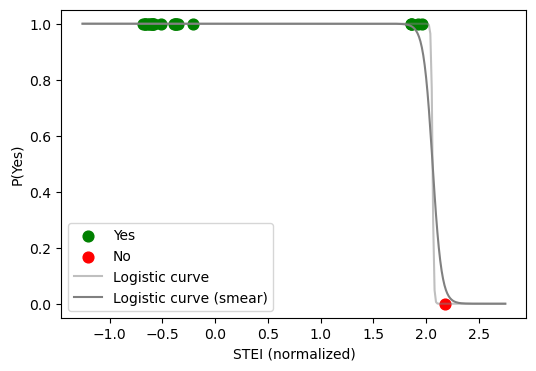

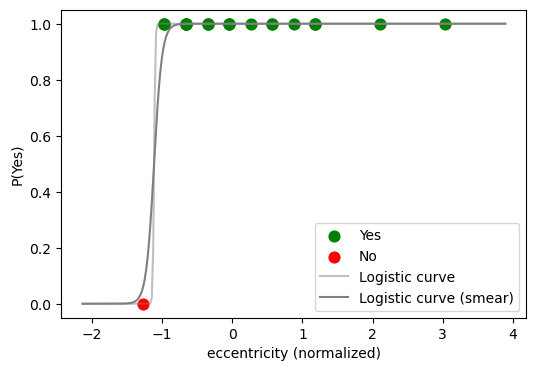

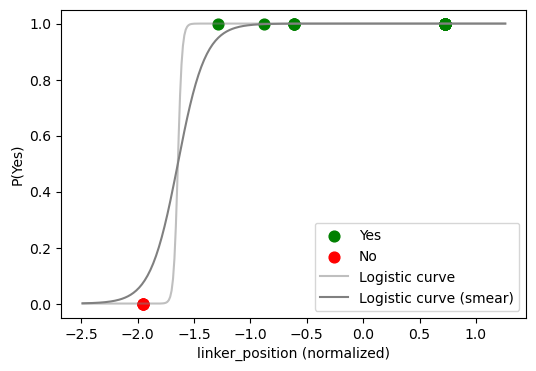

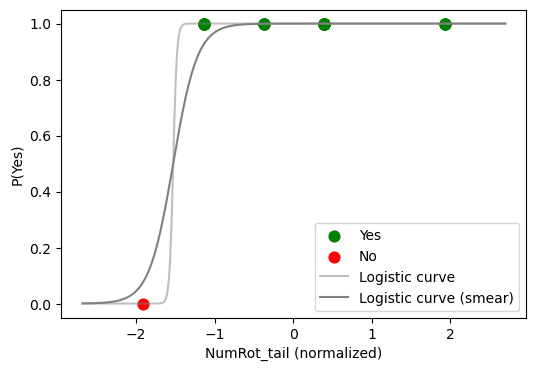

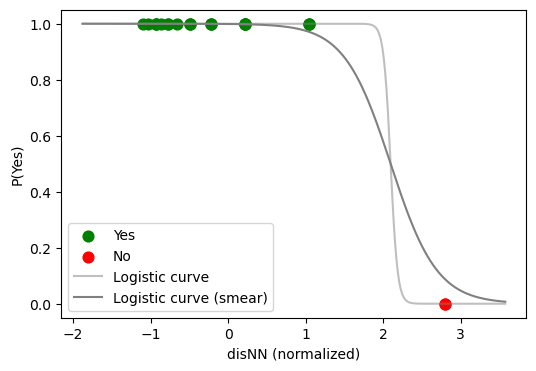

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit  # this is the logistic sigmoid function

sigmoid_parameters_dict = {}
threshold_type_dict = {
    'STEI': 'maximum',
    'eccentricity': 'minimum',
    
    'linker_position': 'minimum',
    'NumRot_tail': 'minimum',
    'disNN': 'maximum',
}

def get_descriptor_value(formability_descriptor, threshold_type):
    if threshold_type == 'maximum':
        maximum_x = max(normalized_formability_descriptors_dataframe.query('reported_2D == "Y"')[formability_descriptor].values)
        query = 'reported_2D == "Y" | '+ str(formability_descriptor) +' > ' + str(maximum_x)
    elif threshold_type == 'minimum':
        minimum_x = min(normalized_formability_descriptors_dataframe.query('reported_2D == "Y"')[formability_descriptor].values)
        query = 'reported_2D == "Y" | '+ str(formability_descriptor) +' < ' + str(minimum_x)
    x = np.array(normalized_formability_descriptors_dataframe.query(query)[formability_descriptor].values)
    y = np.array(normalized_formability_descriptors_dataframe.query(query).reported_2D.values)
    # convert the 'Y' and 'N' to 1 and 0
    y = np.where(y == 'Y', 1, 0)
    return x, y

# Logistic function
def logistic(x, a, b):
    return expit(a * (x + b))  # equivalent to 1 / (1 + exp(-a*(x + b)))

# Negative log likelihood
def nll(params):
    a, b = params
    probs = logistic(x, a, b)
    # Avoid log(0) by clipping probabilities
    probs = np.clip(probs, 1e-9, 1 - 1e-9)
    return -np.sum(y * np.log(probs) + (1 - y) * np.log(1 - probs))

# Initial guess
for descriptor, threshold_type in threshold_type_dict.items():
    x, y = get_descriptor_value(descriptor, threshold_type)
    print(f"Descriptor: {descriptor}, Threshold type: {threshold_type}")
    if descriptor == 'NumRot_tail':
        x = np.concatenate([x, np.array([-1.914,])])
        y = np.concatenate([y, np.array([0,])])
    if threshold_type == 'minimum':
        initial_params = [1.0, 0.0]
    else:
        initial_params = [-1.0, 0.0]
    result = minimize(nll, initial_params)
    a_fit, b_fit = result.x
    print(f"Fitted parameters: a = {a_fit:.4f}, b = {b_fit:.4f}")
    sigmoid_parameters_dict[descriptor] = {'a': a_fit, 'b': b_fit}

    # Plot
    x_plot = np.linspace(min(x) - 0.2*(max(x)-min(x)), max(x) +  + 0.2*(max(x)-min(x)), 300)
    y_plot = logistic(x_plot, a_fit, b_fit)
    y_plot_smeared = logistic(x_plot, a_fit*0.15, b_fit)

    plt.figure(figsize=(6, 4))
    plt.scatter(x[y == 1], y[y == 1], color='green', label='Yes', s=60)
    plt.scatter(x[y == 0], y[y == 0], color='red', label='No', s=60)
    plt.plot(x_plot, y_plot, label='Logistic curve', color='grey', alpha=0.5)
    plt.plot(x_plot, y_plot_smeared, label='Logistic curve (smear)', color='grey')
    plt.xlabel(str(descriptor)+' (normalized)')
    plt.ylabel("P(Yes)")
    plt.legend()
    #plt.grid(True)
    #plt.show()

    # save the figures
    #plt.savefig('../rawfigures/'+descriptor+'_threshold.svg')


In [7]:
combined_params = {}

for key in sigmoid_parameters_dict:
    combined_params[key] = {**sigmoid_parameters_dict.get(key, {}), **scaler_params_dict.get(key, {})}

# save parameters_dict to file
import json
with open(PROJECT_ROOT_DIRECTORY+'01-rawdata/13-existing-molecule/parameters_dict.json', 'w') as f:
    json.dump(combined_params, f, indent=4)



In [8]:
from synthesis_feasibility_helper import calculate_formability_score

In [9]:
# calculate the formability score for the existing molecules

formability_score_list = []
for index, row in reported_formability_descriptors_dataframe.iterrows():
    formability_descriptors_dict = {
        'STEI': row['STEI'],
        'eccentricity': row['eccentricity'],
        'disNN': row['disNN'],
        'linker_position': row['linker_position'],
        'NumRot_tail': row['NumRot_tail']
    }
    formability_score = calculate_formability_score(formability_descriptors_dict, smearing_factor=0.15)
    formability_score['existing_identifier'] = row['existing_identifier']
    formability_score['reported_2D'] = row['reported_2D']
    formability_score['smiles_canonical'] = row['smiles_canonical']
    formability_score_list.append(formability_score)

formability_score_dataframe = pd.DataFrame(formability_score_list)
formability_score_dataframe

,STEI_score,eccentricity_score,linker_position_score,NumRot_tail_score,disNN_score,formability_score,existing_identifier,reported_2D,smiles_canonical
0,1.000000,0.999680,1.000000,0.926551,0.998078,0.984862,1,Y,[NH3+]c1ccc([NH3+])cc1
1,1.000000,0.932433,0.999779,0.926551,0.971660,0.966085,2,Y,[NH3+]c1cccc([NH3+])c1
2,1.000000,1.000000,1.000000,0.999996,0.999819,0.999963,3,Y,[NH3+]Cc1ccc(C[NH3+])cc1
3,1.000000,1.000000,1.000000,0.999996,0.999819,0.999963,4,Y,[NH3+]CCc1ccc([NH3+])cc1
4,1.000000,1.000000,1.000000,1.000000,0.999932,0.999986,5,Y,[NH3+]CCc1ccc(CC[NH3+])cc1
5,1.000000,1.000000,1.000000,0.999996,0.999819,0.999963,6,Y,[NH3+]Cc1c(F)c(F)c(C[NH3+])c(F)c1F
6,0.991996,0.999680,1.000000,0.926551,0.998078,0.983261,7,Y,[NH3+]Cc1cc[nH+]cc1
7,0.962121,0.932433,0.999779,0.926551,0.971660,0.958509,8,Y,[NH3+]Cc1ccc[nH+]c1
8,0.989718,0.999999,1.000000,0.999455,0.999560,0.997746,9,Y,[NH3+]CCc1cc[nH+]cc1
9,0.915433,0.932433,0.999779,0.926551,0.971660,0.949171,10,Y,CC([NH3+])c1ccc[nH+]c1


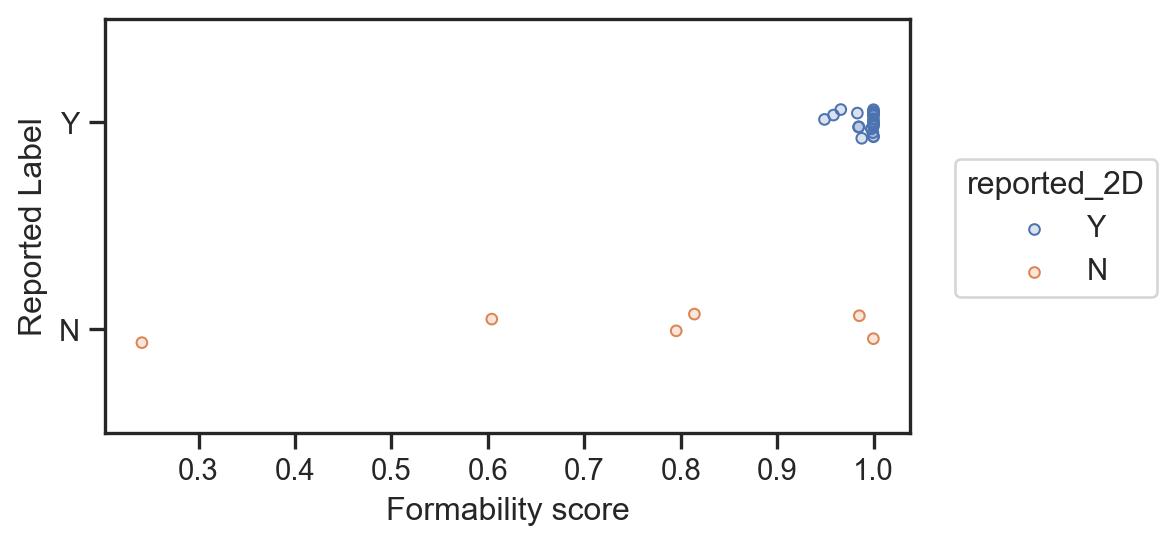

In [10]:
(
    so.Plot(data=formability_score_dataframe,x='formability_score',y='reported_2D',color='reported_2D')
    .add(so.Dots(),so.Jitter())
    .theme(axes_style('ticks'))
    .layout(size=(5,3))
    .label(x='Formability score', y='Reported Label')
    .save('../rawfigures/formability_score.svg')
)

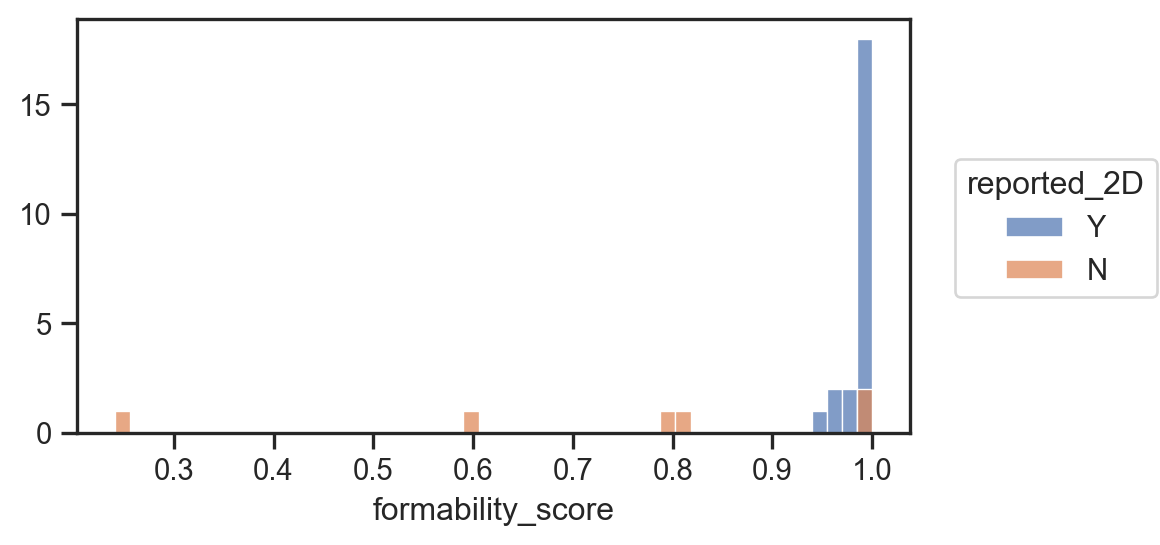

In [11]:
(
    so.Plot(data=formability_score_dataframe,x='formability_score',color='reported_2D')
    .add(so.Bars(),so.Hist(bins=50))
    .theme(axes_style('ticks'))
    .layout(size=(5,3))
    #.save('../rawfigures/formability_score_2.svg')
)

In [15]:
formability_score_dataframe

,STEI_score,eccentricity_score,linker_position_score,NumRot_tail_score,disNN_score,formability_score,existing_identifier,reported_2D,smiles_canonical
0,1.000000,0.999680,1.000000,0.926551,0.998078,0.984862,1,Y,[NH3+]c1ccc([NH3+])cc1
1,1.000000,0.932433,0.999779,0.926551,0.971660,0.966085,2,Y,[NH3+]c1cccc([NH3+])c1
2,1.000000,1.000000,1.000000,0.999996,0.999819,0.999963,3,Y,[NH3+]Cc1ccc(C[NH3+])cc1
3,1.000000,1.000000,1.000000,0.999996,0.999819,0.999963,4,Y,[NH3+]CCc1ccc([NH3+])cc1
4,1.000000,1.000000,1.000000,1.000000,0.999932,0.999986,5,Y,[NH3+]CCc1ccc(CC[NH3+])cc1
5,1.000000,1.000000,1.000000,0.999996,0.999819,0.999963,6,Y,[NH3+]Cc1c(F)c(F)c(C[NH3+])c(F)c1F
6,0.991996,0.999680,1.000000,0.926551,0.998078,0.983261,7,Y,[NH3+]Cc1cc[nH+]cc1
7,0.962121,0.932433,0.999779,0.926551,0.971660,0.958509,8,Y,[NH3+]Cc1ccc[nH+]c1
8,0.989718,0.999999,1.000000,0.999455,0.999560,0.997746,9,Y,[NH3+]CCc1cc[nH+]cc1
9,0.915433,0.932433,0.999779,0.926551,0.971660,0.949171,10,Y,CC([NH3+])c1ccc[nH+]c1


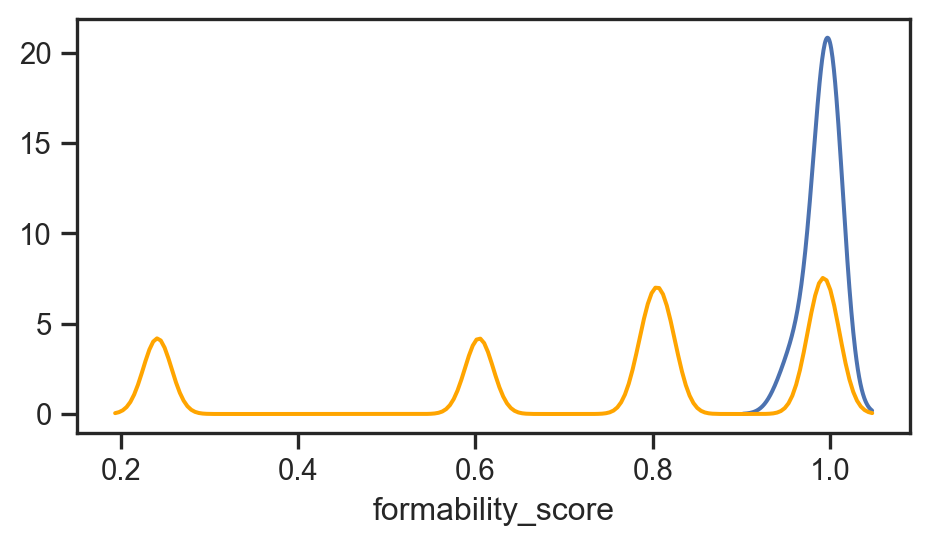

In [37]:
# plot the kernel density estimation of the formability score
(
    so.Plot(data=formability_score_dataframe.query("reported_2D == 'Y'"),x='formability_score',color='reported_2D')
    .add(so.Line(),so.KDE(bw_adjust=2),data=formability_score_dataframe.query("reported_2D == 'Y'"))
    .add(so.Line(color='orange'),so.KDE(bw_adjust=0.08),data=formability_score_dataframe.query("reported_2D == 'N'"))
    .theme(axes_style('ticks'))
    #.limit(x=(0.8,1),y=(-0.5,0.5))
    .layout(size=(5,3))
    #.save('../rawfigures/formability_score_2.svg')
)